This notebook performs an error scaling analysis for the entire volume. In particular, ERL and other metrics  from skeleton error analysis are calculated for various sizes of tissue to see if any scaling behavior can be deduced empirically. The notebook assumes that superblocks of various sizes have been generated and saved using the SegPrep module already. 

In [1]:
from cerebellum.utils.data_io import read_json
import numpy as np

# set params
wz_thresh = 0.5
pred_superblock_type = 'waterz%.2f-48nm-crop2gt-linear-superblock'%(wz_thresh) # base name of superblock
superblock_steps = [1, 2, 4, 8, 12, 16] # various stages of assembly for analysis
n_slices = 60 # # z-slices per block
block_extent = n_slices*30/1000 # z-extent of block in microns
distance = np.multiply(np.array(superblock_steps), block_extent)
n_voxels = np.multiply(np.array(superblock_steps), n_slices)

/home/srujanm/anaconda2/envs/em/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
vi_split = np.zeros(len(superblock_steps))
vi_merge = np.zeros(len(superblock_steps))
trl_pred = np.zeros(len(superblock_steps))
erl_pred = np.zeros(len(superblock_steps))
trl_gt = np.zeros(len(superblock_steps))
erl_gt = np.zeros(len(superblock_steps))
merge_loss = np.zeros(len(superblock_steps))
split_loss = np.zeros(len(superblock_steps))
om_loss = np.zeros(len(superblock_steps))
n_correct = np.zeros(len(superblock_steps))
for i, n_blocks in enumerate(superblock_steps):
    pred_superblock_name = pred_superblock_type + '-%dblocks'%(n_blocks)
    results_folder = './err-analysis/' + pred_superblock_name
    vi = read_json(results_folder+'/vi.json')
    sk_summary = read_json(results_folder+'/skeleton-analysis-summary.json')["results"]
    vi_split[i] = vi["VI split"]
    vi_merge[i] = vi["VI merge"]
    trl_pred[i] = sk_summary["trl-pred"]/10**6 # mm
    erl_pred[i] = sk_summary["erl-pred"]/1000 # um
    trl_gt[i] = sk_summary["trl-gt"]/10**6
    erl_gt[i] = sk_summary["erl-gt"]/1000
    merge_loss[i] = sk_summary["merged-rl"]/10**6
    split_loss[i] = sk_summary["split-rl"]/10**6
    om_loss[i] = sk_summary["omitted-rl"]/10**6
    n_correct[i] = sk_summary["correct"]
    
print "GT ERL (mm) for full volume: %d um"%(erl_gt[-1])
print "Prediction ERL (mm) for full volume: %d um"%(erl_pred[-1])

GT ERL (mm) for full volume: 39 um
Prediction ERL (mm) for full volume: 4 um


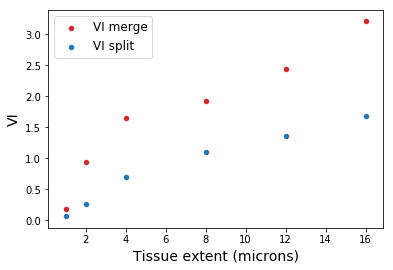

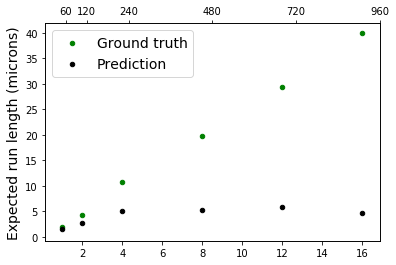

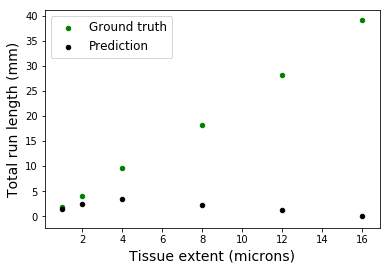

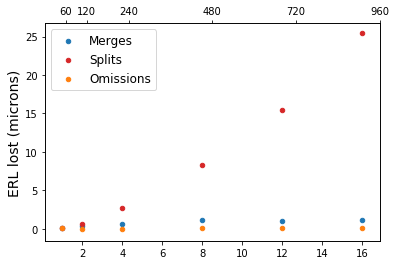

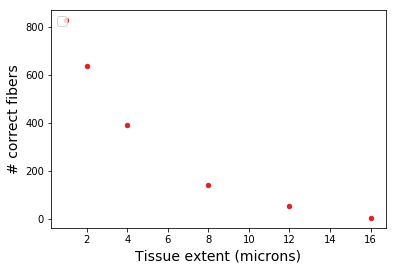

In [3]:
import matplotlib.pyplot as plt

% matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(distance, vi_merge, s=20, c='#d62728', label="VI merge")
ax1.scatter(distance, vi_split, s=20, label="VI split")
plt.xlabel("Tissue extent (microns)", fontsize=14)
plt.ylabel("VI", fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()
# THIS IS WRONG - THE "MERGES" ARE ALL SPLITS BECAUSE THEY ARE MERGES WITH ZERO INCLUDED. FIX IT

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(distance, erl_gt, s=20, c='g', label="Ground truth")
ax1.scatter(distance, erl_pred, s=20, c= 'k', label="Prediction")
#plt.xlabel("Tissue extent (microns)", fontsize=14)
plt.ylabel("Expected run length (microns)", fontsize=14)
plt.legend(loc='upper left', fontsize=14)
ax2 = ax1.twiny()
ax2.set_xticks(distance)
ax2.set_xticklabels(n_voxels)
#ax2.set_xlabel("# voxels in slice direction")
plt.show()

# repeat error analysis - fixed bug in TRL
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(distance, trl_gt, s=20, c='g', label="Ground truth")
ax1.scatter(distance, trl_pred, s=20, c= 'k', label="Prediction")
plt.xlabel("Tissue extent (microns)", fontsize=14)
plt.ylabel("Total run length (mm)", fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(distance,  merge_loss, s=20, label="Merges")
ax1.scatter(distance, split_loss, s=20, c='#d62728', label="Splits")
ax1.scatter(distance, om_loss, s=20,  label="Omissions")
#plt.xlabel("Tissue extent (microns)", fontsize=14)
plt.ylabel("ERL lost (microns)", fontsize=14)
plt.legend(loc='upper left', fontsize=12)
ax2 = ax1.twiny()
ax2.set_xticks(distance)
ax2.set_xticklabels(n_voxels)
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(distance, n_correct, s=20, c='#d62728')
plt.xlabel("Tissue extent (microns)", fontsize=14)
plt.ylabel("# correct fibers", fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()

Can we fit the errors to an exponential model?

Fiber loss rate: 0.245725 /um


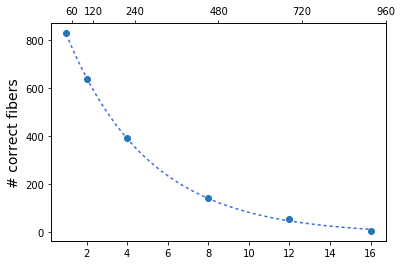

In [4]:
from scipy.optimize import curve_fit

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c

popt, pcov = curve_fit(exponenial_func, distance, n_correct, p0=(800, 4, 0))
print "Fiber loss rate: %f /um"%(popt[1])

xx = np.multiply(np.arange(1,n_blocks,0.1), block_extent)
yy = exponenial_func(xx, *popt)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(distance, n_correct,'o')
ax1.plot(xx, yy, label="fit", c="royalblue", dashes=[2,2])
#plt.plot(distance, n_correct,'o', xx, yy)
fig = plt.gcf()
#plt.xlabel("Tissue extent (microns)", fontsize=14)
plt.ylabel("# correct fibers", fontsize=14)
ax2 = ax1.twiny()
ax2.set_xticks(distance)
ax2.set_xticklabels(n_voxels)
plt.show()